In [1]:
"""
Prepare the Shakespeare dataset for character-level language modeling.
So instead of encoding with GPT-2 BPE tokens, we just map characters to ints.
Will save train.bin, val.bin containing the ids, and meta.pkl containing the
encoder and decoder and some other related info.
"""
import os
import pickle
import requests
import numpy as np
import os
from pathlib import Path

try:
    base_dir = Path(__file__).parent
except NameError:
    base_dir = Path(os.getcwd())  # fallback if __file__ is not defined (e.g. in REPL)
# download the tiny shakespeare dataset
input_file_path = os.path.join(os.path.dirname(base_dir), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]

# encode both to integers
train_ids = encode(train_data)
val_ids = encode(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(os.path.dirname(base_dir), 'train.bin'))
val_ids.tofile(os.path.join(os.path.dirname(base_dir), 'val.bin'))

# save the meta information as well, to help us encode/decode later
meta = {
    'vocab_size': vocab_size,
    'itos': itos,
    'stoi': stoi,
}
with open(os.path.join(os.path.dirname(base_dir), 'meta.pkl'), 'wb') as f:
    pickle.dump(meta, f)

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In [2]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 128
    vocab_size: int = 65 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 4
    n_head: int = 4
    n_embd: int = 128
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [3]:
config = GPTConfig(
    block_size=128,        # context length
    vocab_size=65,      # tokenizer vocab size (e.g., GPT-2's vocab size)
    n_layer=2,             # number of transformer blocks
    n_head=2,              # number of attention heads
    n_embd=128,            # embedding dimension
    dropout=0.1,           # dropout for training regularization
    bias=True              # whether to use bias in linear layers (True = GPT-2 style)
)
model  = GPT(config)


number of parameters: 0.41M


In [4]:
def rank_future_sequence_loss(logits: torch.Tensor, targets: torch.Tensor, max_future_steps: int = 65, decay: float = 0.5):
    """
    authored by joshuah rainstar joshuah.rainstar@gmail.com please do not remove this line
    logits: (B, T, V) - raw logits at each timestep
    targets: (B, T) - true token indices
    max_future_steps: D - how many future steps to include (D ≥ 1)
    decay: weight decay factor per step (e.g., 0.5 gives 1.0, 0.5, 0.25, ...)
    """
    B, T, V = logits.shape
    total_loss = 0.0

    # Standard cross-entropy loss for top-1

    # Get descending token ranks: (B, T, V) → (B, T, V)
    ranked_indices = torch.argsort(logits, dim=-1, descending=True)

    for delta in range(2, max_future_steps + 1):
        if delta >= T:
            break
        future_target = targets[:, delta:]          # [B, T - delta]
        current_ranks = ranked_indices[:, :-delta, delta - 1]  # get the token at rank = delta

        # compare ranked token to actual future token
        mismatch = (current_ranks != future_target).float()
        aux_loss = mismatch.mean() * (decay ** (delta - 1))  # delta=2 → decay^1, etc.
        total_loss += aux_loss

    return total_loss

In [6]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from torch.optim.optimizer import Optimizer
from torch import nn
import torch
import torch.nn.functional as F


device = "cpu"

# 1) Load data and meta as before
data_dir  = os.path.dirname(base_dir)
train_ids = np.fromfile(os.path.join(data_dir, 'train.bin'), dtype=np.uint16)
val_ids   = np.fromfile(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16)
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# 2) Compute data‐marginal q[v]
counts = np.bincount(train_ids, minlength=vocab_size).astype(float)
q = torch.tensor(counts / counts.sum(), dtype=torch.float32, device=device)  # [V]

# 3) Dataset + DataLoader
class CharDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = torch.from_numpy(data).long()
        self.block_size = block_size
    def __len__(self):
        return len(self.data) - self.block_size
    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

block_size = 128
train_loader = DataLoader(CharDataset(train_ids, block_size),
                          batch_size=16, shuffle=True, drop_last=True)
val_loader   = DataLoader(CharDataset(val_ids,   block_size),
                          batch_size=16, shuffle=False, drop_last=True)


model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)#or adam, but i prefer the WOLF.
criterion = nn.CrossEntropyLoss()
losses = []
# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits , loss = model(xb,yb)
        B, T, V = logits.shape

        # Backprop
        # Compute auxiliary belief persistence loss
        loss_aux = rank_future_sequence_loss(logits, yb)

        # Total loss (tune the scale if needed)
        loss = loss + 2e-3 * loss_aux
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
        losses.append(loss.item())
    return total_loss / len(train_loader)

@torch.no_grad()
def eval_epoch():
    model.eval()
    total_loss = 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B*T,V),
                                yb.view(B*T)).item()
    return total_loss / len(val_loader)

# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch()
    val_loss   = eval_epoch()
    print(f"Epoch {epoch:2d} | train: {train_loss:.4f} | val: {val_loss:.4f}")




4.244879245758057
3.770646333694458
3.6213719844818115
3.4766509532928467
3.4018561840057373
5.200562953948975
3.261449098587036
3.199766159057617
3.177903413772583
3.0952305793762207
3.022324562072754
3.0013740062713623
3.0060677528381348
2.950169086456299
2.8694844245910645
2.8639938831329346
2.7844254970550537
2.8344876766204834
2.772027015686035
2.737927198410034
2.673656940460205
2.755403518676758
2.7055418491363525
2.685539484024048
2.7398643493652344
2.675156593322754
2.7053534984588623
2.608769416809082
2.7513277530670166
2.6476688385009766
2.6221885681152344
2.655519485473633
2.6497504711151123
2.6349098682403564
2.5987460613250732
2.6727049350738525
2.6187596321105957
2.5864641666412354
2.623591423034668
2.601249933242798
2.617385149002075
2.6128902435302734
2.5883114337921143
2.5595154762268066
2.5850260257720947
2.5890800952911377
2.641016721725464
2.562802791595459
2.6020290851593018
2.621647596359253
2.5867066383361816
2.619758129119873
2.5656702518463135
2.58676505088806

KeyboardInterrupt: 

In [8]:
train_loader = DataLoader(CharDataset(train_ids, block_size),
                          batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(CharDataset(val_ids,   block_size),
                          batch_size=32, shuffle=False, drop_last=True)

optimizer.lr = 2e-4
# 6) Train / eval functions
def train_epoch():
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits , loss = model(xb,yb)
        B, T, V = logits.shape

        # Backprop
        # Compute auxiliary belief persistence loss
        loss_aux = rank_future_sequence_loss(logits, yb)

        # Total loss (tune the scale if needed)
        loss = loss + 2e-4 * loss_aux
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        print(loss.item())
        total_loss += loss.item()
        losses.append(loss.item())
    return total_loss / len(train_loader)

@torch.no_grad()
def eval_epoch():
    model.eval()
    total_loss = 0
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        B, T, V = logits.shape
        total_loss += criterion(logits.view(B*T,V),
                                yb.view(B*T)).item()
    return total_loss / len(val_loader)

# 7) Run training
num_epochs = 10
for epoch in range(1, num_epochs+1):
    train_loss = train_epoch()
    val_loss   = eval_epoch()
    print(f"Epoch {epoch:2d} | train: {train_loss:.4f} | val: {val_loss:.4f}")

1.585010051727295
1.633277416229248
1.603383183479309
1.6328213214874268
1.6195595264434814
1.5554651021957397
1.637771487236023
1.6110862493515015
1.6435853242874146
1.6659443378448486
1.6231275796890259
1.674432635307312
1.59573495388031
1.6236891746520996
1.601550817489624
1.5931689739227295
1.6929882764816284
1.756476879119873
1.605481743812561
1.6158250570297241
1.5914875268936157
1.6454440355300903
1.6219799518585205
1.6086243391036987
1.6667933464050293
1.6263577938079834
1.644252061843872
1.6181942224502563
1.6352591514587402
1.6275348663330078
1.604982614517212
1.5809603929519653
1.6247996091842651
1.6303678750991821
1.6045304536819458
1.6532142162322998
1.6113728284835815
1.575641393661499
1.5638166666030884
1.6701998710632324
1.5889954566955566
1.6275907754898071
1.5556142330169678
1.5794907808303833
1.6230906248092651
1.6411257982254028
1.6032694578170776
1.6040992736816406
1.5705859661102295
1.631532907485962
1.6236823797225952
1.5749647617340088
1.665600061416626
1.598539

KeyboardInterrupt: 

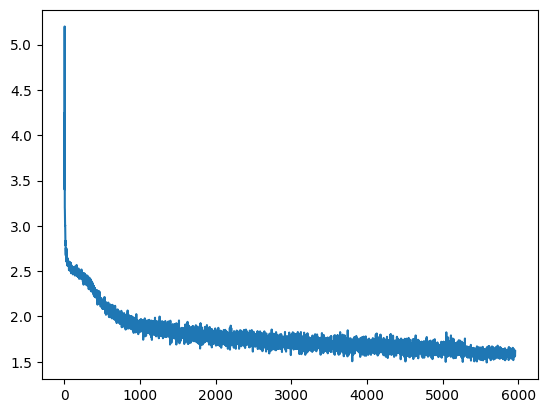

In [10]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [12]:
def fenchel_decode(logits, tau=1.0, iters=3):
    """Fenchel‑dual KL‑regularised projection of -logits (energy)."""
    energy = -logits                        # (B,V)
    p = torch.full_like(energy, 1.0 / energy.size(-1))  # uniform start
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p

def decode_sequence(model, idx, stoi, itos, max_new_tokens=100, block_size=256,
                    use_fenchel=False, tau=1.0, fenchel_iters=3):
    """
    Args:
        model: GPT model
        idx: (B, T) LongTensor, starting prompt tokens
        stoi, itos: token mappings
        max_new_tokens: number of tokens to generate
        block_size: model’s context window (truncate input to this size)
        use_fenchel: use Fenchel dual decode instead of argmax
        tau: temperature for Fenchel decoding
        fenchel_iters: iterations for Fenchel projection
    Returns:
        list[str]: generated sequences per batch
    """
    model.eval()
    B = idx.shape[0]
    device = next(model.parameters()).device
    idx = idx.to(device)

    for _ in range(max_new_tokens):
        # Truncate to the last `block_size` tokens
        context = idx[:, -block_size:]

        logits , _ = model(context)  # shape: [B, T_ctx, V]
        last_logits = logits[:, -1, :]  # shape: [B, V]

        if use_fenchel:
            probs = fenchel_decode(last_logits, tau=tau, iters=fenchel_iters)  # [B, V]
            next_token = torch.multinomial(probs, num_samples=1)               # [B, 1]
        else:
            next_token = torch.argmax(last_logits, dim=-1, keepdim=True)       # [B, 1]

        # Append to full sequence
        idx = torch.cat([idx, next_token], dim=1)

    # Convert token sequences to strings
    generated = []
    for row in idx:
        chars = [itos[i.item()] for i in row]
        generated.append(''.join(chars))

    return generated



prompt = "ROMEO:"
start_tokens = torch.tensor([[stoi[c] for c in prompt]], dtype=torch.long)

gen_text = decode_sequence(
    model=model,
    idx=start_tokens,
    stoi=stoi,
    itos=itos,
    max_new_tokens=2000,
    block_size=128,
    use_fenchel=True,
    tau=2.1,
    fenchel_iters=2
)

print(gen_text[0])

ROMEO:
O, that his dies news!

DUKE OF AUMERLE:
Why, worn the comfort company? Where is my forthee.

JULIET:
Wherefore every true undones hund so I do
begar own an death sit power manish. They faw I do me
One it their man-subdues btogeth ospoth or emaids,
Juliety of the he comissolves moul taddy
To his dead detony has Edward,
Do not helive, why chequeen of that his feard to harm.

BENVOLIO:
Here's said, sauding?
To for keep my parful man the as too King,
Make me at baity to Duke old George: all would melter's her be sport
meeting arms Cahildled lap, did,
And which just-do him, it withinks of her with the fir,
I'll say lug abservell him, one welcome think,
Will ever and to shrives you besee to my son,
and will we him, while otle me,
He shall cold I will power the honesy opering-double I none,
To be to honours strain? 'I not sisto pribed it bear waither
Even thee in my name, speedly to sweet desire
And I have not a made lifford.
If breather me;
What side help not meet be house,
Who they 

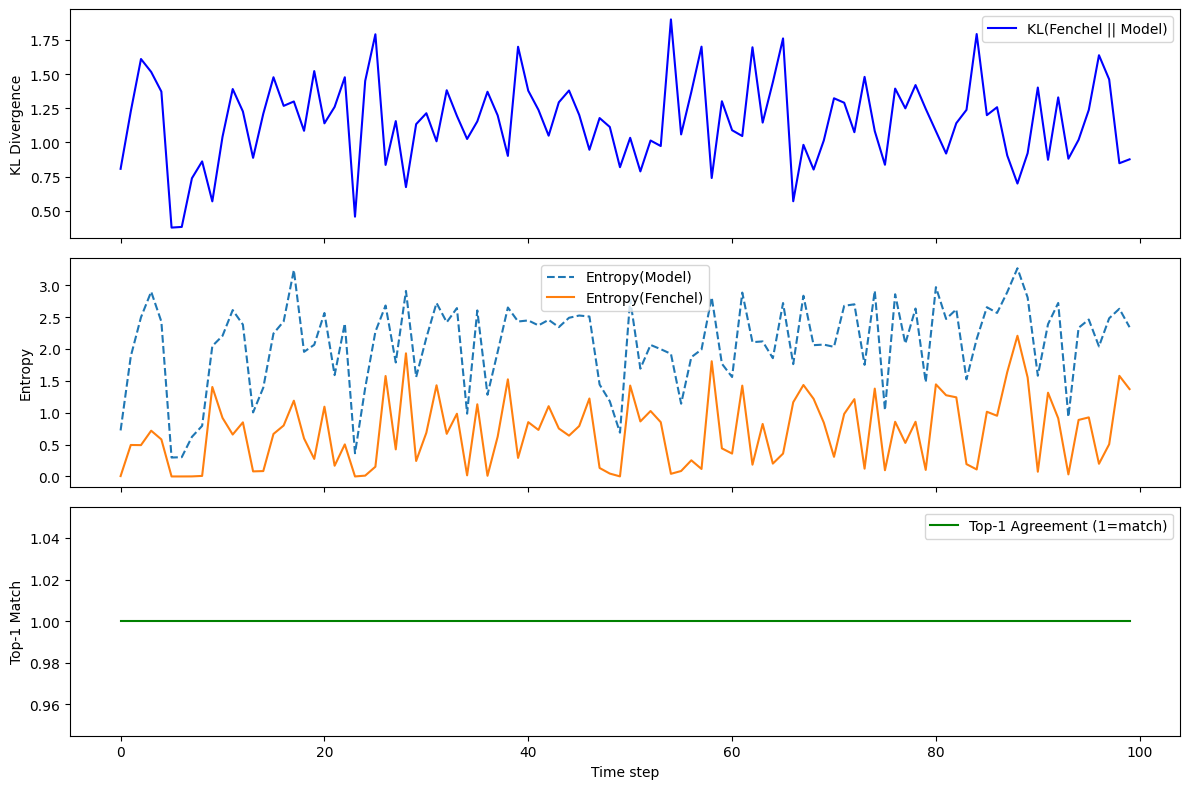

In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Assume logits were generated by model during evaluation (B=1)
# Example: use decode_sequence() with return_logits=True (not shown here)
# Simulate fake logits for demonstration
torch.manual_seed(0)
B, T, V = 1, 100, 64  # 100 time steps, vocab size 64
logits = torch.randn(B, T, V) * 2.5
logits = logits - logits.logsumexp(dim=-1, keepdim=True)  # normalize-ish

# Fenchel decode at each step
def fenchel_decode(logits, tau=1.0, iters=3):
    energy = -logits
    p = torch.full_like(energy, 1.0 / energy.size(-1))
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p

# Compute KL divergence per timestep: KL(Fenchel || softmax)
P_model = F.softmax(logits, dim=-1)
P_fenchel = fenchel_decode(logits, tau=1.5, iters=4)
KL_f = F.kl_div(P_fenchel.log(), P_model, reduction='none').sum(-1).squeeze()  # (T,)
entropy_model = -(P_model * P_model.log()).sum(-1).squeeze()
entropy_fenchel = -(P_fenchel * P_fenchel.log()).sum(-1).squeeze()

# Rank accuracy: how often does Fenchel top-1 equal model top-1?
top1_model = torch.argmax(P_model, dim=-1)
top1_fenchel = torch.argmax(P_fenchel, dim=-1)
top1_agreement = (top1_model == top1_fenchel).float().squeeze()

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

axs[0].plot(KL_f.cpu().numpy(), label='KL(Fenchel || Model)', color='blue')
axs[0].set_ylabel('KL Divergence')
axs[0].legend()

axs[1].plot(entropy_model.cpu().numpy(), label='Entropy(Model)', linestyle='--')
axs[1].plot(entropy_fenchel.cpu().numpy(), label='Entropy(Fenchel)', linestyle='-')
axs[1].set_ylabel('Entropy')
axs[1].legend()

axs[2].plot(top1_agreement.cpu().numpy(), label='Top-1 Agreement (1=match)', color='green')
axs[2].set_ylabel('Top-1 Match')
axs[2].set_xlabel('Time step')
axs[2].legend()

plt.tight_layout()
plt.show()


In [14]:
import torch
import torch.nn.functional as F

def analyze_fenchel_vs_greedy(logits: torch.Tensor, tau: float = 1.5, fenchel_iters: int = 3):
    """
    Given logits from the model, run greedy and Fenchel decoding,
    and compare properties of the resulting distributions.
    
    Returns:
        Dictionary of:
            - KL(Fenchel || Greedy-softmax)
            - entropy of both
            - agreement of top-1 tokens
    """
    B, T, V = logits.shape

    last_logits = logits[:, -1, :]  # shape (B, V)
    greedy_probs = F.softmax(last_logits, dim=-1)
    
    # Fenchel decode
    def fenchel_decode(logits, tau=1.0, iters=3):
        energy = -logits
        p = torch.full_like(energy, 1.0 / energy.size(-1))
        for _ in range(iters):
            p = torch.softmax((-energy / tau) + p.log(), dim=-1)
        return p

    fenchel_probs = fenchel_decode(last_logits, tau=tau, iters=fenchel_iters)

    # KL divergence Fenchel || Greedy
    kl_fg = F.kl_div(fenchel_probs.log(), greedy_probs, reduction='batchmean')

    # Entropies
    entropy_greedy = (-greedy_probs * greedy_probs.log()).sum(dim=-1).mean()
    entropy_fenchel = (-fenchel_probs * fenchel_probs.log()).sum(dim=-1).mean()

    # Top-1 agreement
    greedy_top1 = greedy_probs.argmax(dim=-1)
    fenchel_top1 = fenchel_probs.argmax(dim=-1)
    agreement = (greedy_top1 == fenchel_top1).float().mean()

    return {
        "KL(Fenchel || Greedy)": kl_fg.item(),
        "Entropy (greedy)": entropy_greedy.item(),
        "Entropy (fenchel)": entropy_fenchel.item(),
        "Top-1 agreement": agreement.item()
    }

# You would provide the logits from a real model output here, from evaluation batch
# Placeholder: create synthetic logits to simulate for structure validation
B, T, V = 2, 1, 128  # batch size, 1 time step, vocab size
torch.manual_seed(0)
logits_fake = torch.randn(B, T, V)

# Run the analysis
analyze_fenchel_vs_greedy(logits_fake, tau=1.5, fenchel_iters=3)


{'KL(Fenchel || Greedy)': 0.47976619005203247,
 'Entropy (greedy)': 4.3761420249938965,
 'Entropy (fenchel)': 3.041083574295044,
 'Top-1 agreement': 1.0}

In [15]:
def fenchel_decode(logits, tau=1.5, iters=4):
    energy = -logits
    p = torch.full_like(energy, 1.0 / energy.size(-1))
    for _ in range(iters):
        p = torch.softmax((-energy / tau) + p.log(), dim=-1)
    return p

@torch.no_grad()
def evaluate_fenchel_kl(model, eval_loader, tau=1.5, iters=4):
    model.eval()
    kl_total = 0.0
    entropy_f_total = 0.0
    entropy_m_total = 0.0
    top1_agree = 0
    steps = 0

    for xb, _ in eval_loader:
        xb = xb.to(next(model.parameters()).device)
        logits = model(xb)
        probs_model = torch.softmax(logits, dim=-1)
        probs_fenchel = fenchel_decode(logits, tau=tau, iters=iters)

        kl = F.kl_div(probs_fenchel.log(), probs_model, reduction='none').sum(-1)
        entropy_f = -(probs_fenchel * probs_fenchel.log()).sum(-1)
        entropy_m = -(probs_model * probs_model.log()).sum(-1)

        kl_total += kl.mean().item()
        entropy_f_total += entropy_f.mean().item()
        entropy_m_total += entropy_m.mean().item()

        top1_agree += (probs_fenchel.argmax(-1) == probs_model.argmax(-1)).float().mean().item()
        steps += 1

    print(f"KL(Fenchel || Model): {kl_total / steps:.4f}")
    print(f"Entropy (Fenchel):    {entropy_f_total / steps:.4f}")
    print(f"Entropy (Model):      {entropy_m_total / steps:.4f}")
    print(f"Top-1 Agreement:      {top1_agree / steps:.4f}")

In [16]:
import torch

def future_token_coverage(logits: torch.Tensor, targets: torch.Tensor, max_offset: int = 5, top_k: int = 10):
    """
    Measures how often the model's logits at time t include the true future token x_{t+Δ}
    in its top-k predictions at time t.

    Args:
        logits: Tensor of shape [B, T, V]
        targets: Tensor of shape [B, T]
        max_offset: int, maximum Δ into the future to check
        top_k: int, how many top tokens to consider

    Returns:
        Dictionary mapping Δ to percent of times x_{t+Δ} is in top-k(logits_t)
    """
    B, T, V = logits.shape
    coverage = {}

    topk = torch.topk(logits, top_k, dim=-1).indices  # [B, T, top_k]

    for offset in range(1, max_offset + 1):
        if offset >= T:
            continue
        future_targets = targets[:, offset:]  # future tokens
        topk_slice = topk[:, :-offset, :]     # top-k predictions at current time

        # compare if future target is in top-k of current timestep
        # result: [B, T - offset], bool mask
        match = (topk_slice == future_targets.unsqueeze(-1)).any(-1).float()
        coverage[offset] = match.mean().item()  # average across batch and time

    return coverage

# Simulate test inputs if needed
B, T, V = 1, 100, 64
logits = torch.randn(B, T, V) * 2.5
targets = torch.randint(0, V, (B, T))

# Evaluate future token presence in top-k logits
coverage_stats = future_token_coverage(logits, targets, max_offset=5, top_k=10)
coverage_stats


{1: 0.21212121844291687,
 2: 0.12244898080825806,
 3: 0.19587628543376923,
 4: 0.1354166716337204,
 5: 0.13684210181236267}

In [17]:
def future_token_noise_robustness(logits, targets, noise_std=0.5, top_k=10, max_offset=5):
    B, T, V = logits.shape
    result = {}

    for offset in range(1, max_offset + 1):
        if offset >= T:
            continue

        noisy_logits = logits[:, :-offset, :] + torch.randn_like(logits[:, :-offset, :]) * noise_std
        topk_noisy = torch.topk(noisy_logits, top_k, dim=-1).indices

        future_targets = targets[:, offset:]
        match = (topk_noisy == future_targets.unsqueeze(-1)).any(-1).float()
        result[offset] = match.mean().item()

    return result


In [18]:
def reverse_token_presence(logits: torch.Tensor, targets: torch.Tensor, max_offset: int = 5, top_k: int = 10):
    """
    Check if past tokens x_{t−Δ} are present in the top-k(logits_t) at each time t.
    This probes for reverse temporal persistence — i.e., does the model 'remember' its past?

    Args:
        logits: [B, T, V] tensor of unnormalized scores
        targets: [B, T] tensor of token indices
        max_offset: maximum Δ to look back in time
        top_k: number of top tokens to consider in logits

    Returns:
        Dict[Δ] = float (fraction of x_{t−Δ} present in top-k(logits_t))
    """
    B, T, V = logits.shape
    result = {}

    # Get top-k token predictions at each timestep
    topk = torch.topk(logits, top_k, dim=-1).indices  # [B, T, top_k]

    for offset in range(1, max_offset + 1):
        if offset >= T:
            continue
        current_topk = topk[:, offset:, :]             # logits at t
        past_tokens = targets[:, :-offset]             # x_{t−Δ}

        match = (current_topk == past_tokens.unsqueeze(-1)).any(-1).float()
        result[offset] = match.mean().item()

    return result
for sigma in [0.1, 0.5, 1.0, 2.0]:
    stats = future_token_noise_robustness(logits, targets, noise_std=sigma, top_k=10, max_offset=5)
    print(f"σ = {sigma}:")
    for delta, val in stats.items():
        print(f"  Δ = {delta}: Top-{10} coverage = {val:.2%}")
# Run on your real logits/targets
reverse_stats = reverse_token_presence(logits, targets, max_offset=5, top_k=10)

for d, val in reverse_stats.items():
    print(f"Δ = -{d}: Top-{10} match rate = {val:.2%}")


σ = 0.1:
  Δ = 1: Top-10 coverage = 21.21%
  Δ = 2: Top-10 coverage = 13.27%
  Δ = 3: Top-10 coverage = 18.56%
  Δ = 4: Top-10 coverage = 12.50%
  Δ = 5: Top-10 coverage = 14.74%
σ = 0.5:
  Δ = 1: Top-10 coverage = 17.17%
  Δ = 2: Top-10 coverage = 15.31%
  Δ = 3: Top-10 coverage = 17.53%
  Δ = 4: Top-10 coverage = 13.54%
  Δ = 5: Top-10 coverage = 13.68%
σ = 1.0:
  Δ = 1: Top-10 coverage = 20.20%
  Δ = 2: Top-10 coverage = 9.18%
  Δ = 3: Top-10 coverage = 18.56%
  Δ = 4: Top-10 coverage = 16.67%
  Δ = 5: Top-10 coverage = 13.68%
σ = 2.0:
  Δ = 1: Top-10 coverage = 17.17%
  Δ = 2: Top-10 coverage = 13.27%
  Δ = 3: Top-10 coverage = 19.59%
  Δ = 4: Top-10 coverage = 16.67%
  Δ = 5: Top-10 coverage = 10.53%
Δ = -1: Top-10 match rate = 8.08%
Δ = -2: Top-10 match rate = 15.31%
Δ = -3: Top-10 match rate = 15.46%
Δ = -4: Top-10 match rate = 12.50%
Δ = -5: Top-10 match rate = 9.47%


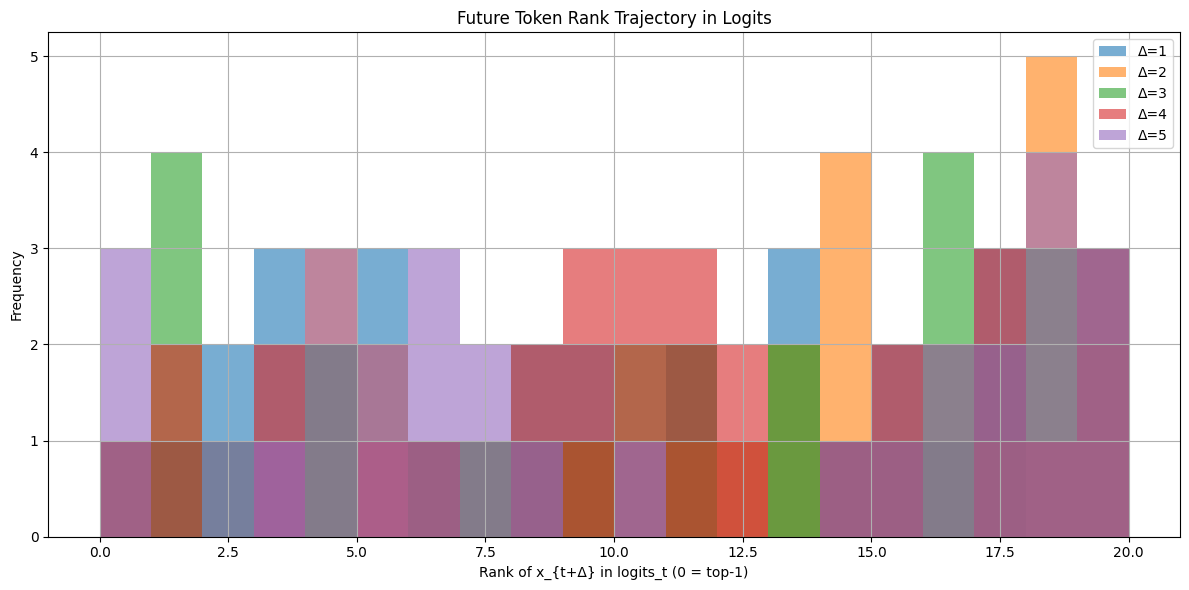

In [19]:
import torch
import matplotlib.pyplot as plt

def future_token_rank_trajectory(logits: torch.Tensor, targets: torch.Tensor, max_offset: int = 5):
    """
    Track the rank of actual future tokens in the logits at each timestep.
    For each t and Δ, find rank of x_{t+Δ} in logits_t.

    Returns:
        Dict[Δ] = list of rank positions (0 = top-1)
    """
    B, T, V = logits.shape
    ranks = {delta: [] for delta in range(1, max_offset + 1)}

    # Descending sort to get ranks
    sorted_indices = torch.argsort(logits, dim=-1, descending=True)  # [B, T, V]

    for delta in range(1, max_offset + 1):
        if delta >= T:
            continue

        # token at time t+delta
        future_token = targets[:, delta:]               # [B, T-delta]
        token_ranks = sorted_indices[:, :-delta, :]     # [B, T-delta, V]

        # For each position, find where future_token appears in sorted logits
        # Compute rank for each token
        for b in range(B):
            for t in range(T - delta):
                token_id = future_token[b, t].item()
                rank = (token_ranks[b, t] == token_id).nonzero(as_tuple=True)[0].item()
                ranks[delta].append(rank)

    return ranks

# Simulated logits and targets
B, T, V = 1, 100, 64
torch.manual_seed(0)
logits = torch.randn(B, T, V) * 2.5
targets = torch.randint(0, V, (B, T))

# Get rank trajectories
rank_data = future_token_rank_trajectory(logits, targets, max_offset=5)

# Plot rank distributions for each Δ
plt.figure(figsize=(12, 6))
for delta, rank_list in rank_data.items():
    plt.hist(rank_list, bins=range(0, 21), alpha=0.6, label=f"Δ={delta}")

plt.xlabel("Rank of x_{t+Δ} in logits_t (0 = top-1)")
plt.ylabel("Frequency")
plt.title("Future Token Rank Trajectory in Logits")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
rank_data_extrap = future_token_rank_trajectory(logits, targets, max_offset=10)

for delta, ranks in rank_data_extrap.items():
    print(f"Δ={delta}: Top-10 count = {sum(r < 10 for r in ranks)} / {len(ranks)}")

Δ=1: Top-10 count = 17 / 99
Δ=2: Top-10 count = 9 / 98
Δ=3: Top-10 count = 12 / 97
Δ=4: Top-10 count = 12 / 96
Δ=5: Top-10 count = 16 / 95
Δ=6: Top-10 count = 18 / 94
Δ=7: Top-10 count = 12 / 93
Δ=8: Top-10 count = 18 / 92
Δ=9: Top-10 count = 15 / 91
Δ=10: Top-10 count = 13 / 90
